In [1]:
import sys
# Assuming we are in the notebook directory add this so that we can import the library
sys.path.append('..')

import numpy as np
import dask
from dask.dot import dot_graph
from elfi.core import *
from elfi.distributions import *
from elfi.methods import Rejection, BOLFI
from elfi.examples.ma2 import MA2, autocov, distance
from elfi.visualization import draw_model
from distributed import Client
from functools import partial

import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

### Generate some toy data

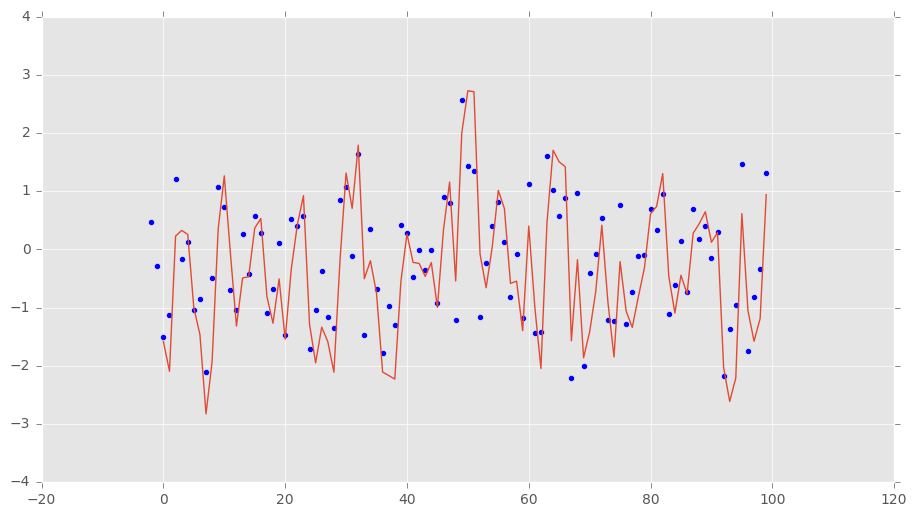

In [2]:
n = 100
t1_0 = 0.6
t2_0 = 0.2

# Set up observed data y
latents = np.random.RandomState(123456).randn(n+2)
#latents = np.random.randn(n+2)
y = MA2(n, 1, t1_0, t2_0, latents=latents)

# Plot
plt.figure(figsize=(11, 6))
plt.plot(np.arange(0,n),y[0,:])
plt.scatter(np.arange(-2,n), latents);

### Setup the simultator and summary functions

In [3]:
# Set up the MA 2 simulator
# Fix n to the same value as in the observed data
simulator = partial(MA2, n)

# Set up autocorrelation summaries for lags 1 and 2
ac1 = partial(autocov, 1)
ac2 = partial(autocov, 2)

In [4]:
print(ac1(y))

[[ 0.47438625]]


In [5]:
print(ac2(y))

[[ 0.05935101]]


### Build the model

In [6]:
# Specify the graphical model
t1 = Prior('t1', 'uniform', 0, 1)
t2 = Prior('t2', 'uniform', 0, 1)
Y = Simulator('MA2', simulator, t1, t2, observed=y)
S1 = Summary('S1', ac1, Y)
S2 = Summary('S2', ac2, Y)
d = Discrepancy('d', distance, S1, S2)

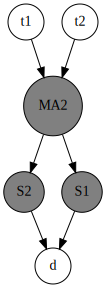

In [7]:
draw_model(d)

In [8]:
S1.generate(5).compute()

array([[ 0.29411535],
       [ 0.57393134],
       [ 0.48126217],
       [ 0.51733865],
       [ 0.25732633]])

In [9]:
d.generate(10).compute()

array([[ 0.32308734],
       [ 0.31071011],
       [ 0.06975544],
       [ 0.12696678],
       [ 0.28836612],
       [ 0.3224707 ],
       [ 0.51857539],
       [ 0.88690753],
       [ 0.46274787],
       [ 0.39223536]])

### Rejection sampling

In [10]:
# Specify the number of samples to sample and set up rejection sampling
n_samples = 1000000
rej = Rejection(n_samples, d, [t1, t2], 10000)

In [11]:
# Time and run the simulator in parallel
%time result = rej.infer(threshold=.05)

CPU times: user 18 s, sys: 1.83 s, total: 19.8 s
Wall time: 4.4 s


### Visualize results

Number of accepted samples 14709 with threshold 0.05
Posterior means: 0.66 0.21


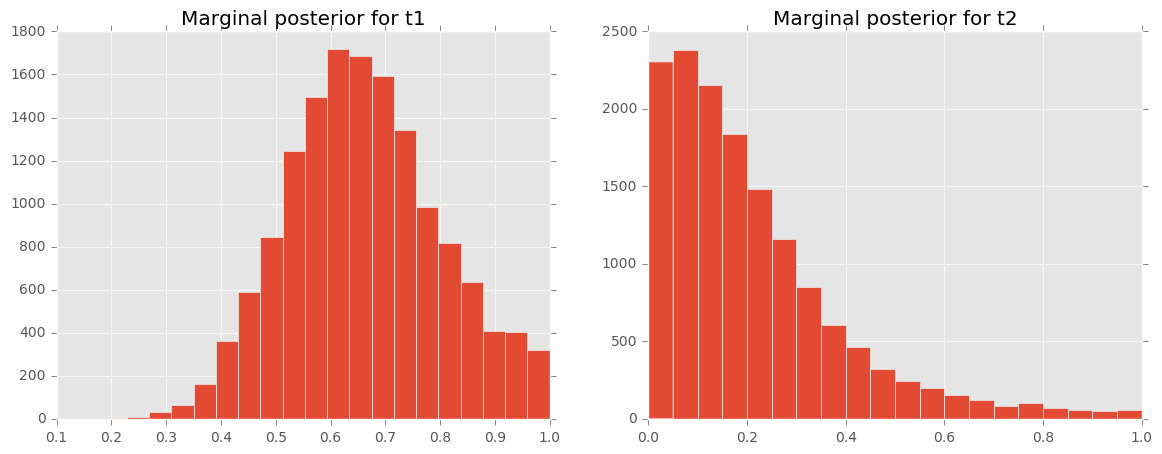

In [12]:
[t1_post, t2_post] = result['samples']
print("Number of accepted samples {} with threshold {:.2f}".format(len(t1_post), result['threshold']))
print("Posterior means: {:.2f} {:.2f}".format(t1_post.mean(), t2_post.mean()))

fig, ax = plt.subplots(ncols=2, figsize=(14,5));
ax[0].hist(t1_post, bins=20);
ax[0].set_title("Marginal posterior for t1");
ax[1].hist(t2_post, bins=20);
ax[1].set_title("Marginal posterior for t2");

In [19]:
# Autocorrelation
print("Autocorrelation")
print("%.2f" % ac1(y))
print("%.2f" % ac2(y))

print("\nPosterior means")
print("%.2f"% t1_post.mean())
print("%.2f"% t2_post.mean())

# True values
print("\nTrue values")
print(t1_0)
print(t2_0)

Autocorrelation
0.47
0.06

Posterior means
0.66
0.21

True values
0.6
0.2
